В этом ноутбуке берется переписанный код статьи и проверяется корректность его запуска, а именно, что итоговые метрики будут похожи на предоставленные в статье.

In [1]:
# выключить среду
# from google.colab import runtime
# runtime.unassign()

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
# %cd '/content/drive/MyDrive/Thesis_masters/TabDDPM'

In [4]:
# !pip freeze

In [5]:
# !python -V

In [6]:
# !pip install -r requirements.txt

In [7]:
# !pip install Click==7.0
# !pip uninstall sdv --yes
# !pip install sdv
# !pip install seaborn
# !pip install nbformat

In [8]:
# !pip install synthcity

In [9]:
# !python -m pip install --upgrade pip
# !pip install sdv

In [10]:
import json
import pandas as pd
import torch
import matplotlib.pyplot as plt

from utils import *
from models.tabddpm.tabddpm import *

In [11]:
with open('./config.json', 'w', encoding='utf-8') as f:
    json.dump({
        'path': 'tabddpm.json',
        'model_name':'tabddpm'
    }, f, ensure_ascii=False, indent=4)

In [12]:
# download_dataset('adult')
# process_data('adult')

Start processing dataset adult from UCI.
Aready downloaded.
adult (32561, 15) (16281, 15) (32561, 15)
Numerical (32561, 6)
Categorical (32561, 8)
Processing and Saving adult Successfully!
adult
Total 48842
Train 32561
Test 16281
Num 6
Cat 9


### Подготовка

In [13]:
model_name = 'tabddpm'
dataname = 'adult'

In [14]:
CONFIG.add_arg('dataname', dataname)
CONFIG.add_arg('method', model_name)

In [15]:
if torch.cuda.is_available():
    device = f'cuda'
else:
    device = 'cpu'
CONFIG.add_arg('device', device)
print(f"Device: {device}")

if not CONFIG.get_arg('save_path'):
    CONFIG.add_arg('save_path',
                   f"synthetic/{CONFIG.get_arg('dataname')}/{CONFIG.get_arg('method')}.csv")

Device: cuda


In [34]:
CONFIG.get_all_args()

{'dataname': 'adult',
 'method': 'tabddpm',
 'device': 'cuda',
 'save_path': 'synthetic/adult/tabddpm.csv',
 'mode': 'train',
 'train': 1,
 'sample_save_path': 'synthetic/adult/tabddpm.csv'}

### Train

In [17]:
CONFIG.add_arg('mode', 'train')

In [18]:
tabddpm = TabDDPM(CONFIG)

In [26]:
# tabddpm.train()

Text(0.5, 1.0, 'Model name: TABDDPM\nLoss by steps from step #10000')

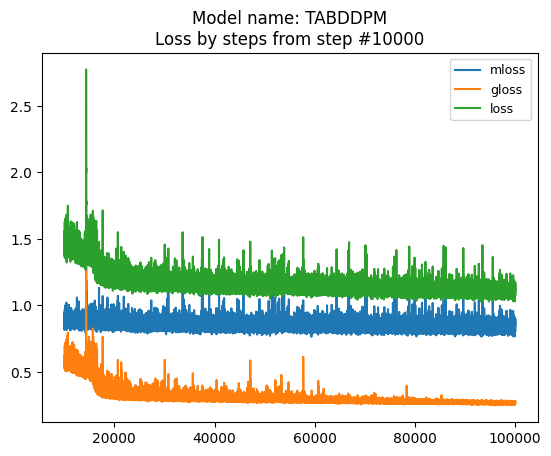

In [25]:
loss = pd.read_csv(f'./models/{model_name}/ckpt/{dataname}/loss.csv')

start_step = 10000
for l in loss.columns[1:]:
  plt.plot(loss['step'][start_step:], loss[l][start_step:], label=l)
plt.legend()
plt.title(f"Model name: {model_name.upper()}\nLoss by steps from step #{start_step}")

In [27]:
# tabddpm.sample(sample_save_path=CONFIG.get_arg('save_path'))

No NaNs in numerical features, skipping
mlp
torch.Size([10000, 104])
Sample timestep    0
torch.Size([10000, 104])
Sample timestep    0
torch.Size([10000, 104])
Sample timestep    0
torch.Size([10000, 104])
Sample timestep    0
Shape torch.Size([32561, 15])
(32561, 9)
Sampling time: 208.7928056716919


### Расчет метрик

In [28]:
from eval.base_metrics import calculate_base_metrics
from eval.similarity import calculate_similarity
from eval.mle import calculate_mle
from eval.alpha_beta import calculate_alpha_beta
from eval.detection import calculate_detection
from eval.dcr import calculate_DCR

In [31]:
CONFIG.get_arg('sample_save_path')

'./generated_samples/adult.csv'

#### Метрики из starter_kit

In [35]:
calculate_base_metrics(make_binary=True, value=' >50K')

/venv/main/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


TABDDPM: ADULT Dataset
Original Logistic: 0.657
Synthetic Logistic: 0.658
Original Tree: 0.661
Synthetic Tree: 0.648 

TABDDPM Accuracy Loss: ADULT
Logistic: -0.098%
Tree: 1.995% 



/venv/main/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


#### Метрики из статьи TabSyn

In [36]:
calculate_similarity()

CALCULATING COLUMN-WISE DENSITY ESTIMATION & PAIR-WISE COLUMN CORRELATION...
Generating report ...

(1/2) Evaluating Column Shapes: |██████████| 15/15 [00:00<00:00, 56.33it/s]|
Column Shapes Score: 98.82%

(2/2) Evaluating Column Pair Trends: |██████████| 105/105 [00:02<00:00, 49.28it/s]|
Column Pair Trends Score: 97.85%

Overall Score (Average): 98.34%

Error rate (%) of column-wise density estimation TABDDPM: 1.175 ± 0.661
Error rate (%) of pair-wise column correlation score TABDDPM: 2.147 ± 1.105


DONE! 

DRAW COLUMN VALUES DISTRIBUTIONS...


DONE!


#### MLE

In [37]:
calculate_mle()

100%|██████████| 36/36 [00:12<00:00,  2.96it/s]


Saving scores to  eval/mle/adult/tabddpm.json
ROC - AUC обучения на синтетических данных TABDDPM: 0.902 ± 0.005


#### Detection: classifier two sample tests (C2ST)

In [38]:
calculate_detection()

adult, tabddpm: 0.9516592856630659


#### DCR

In [39]:
calculate_DCR()

DCR Score, a value closer to 0.5 is better
adult-tabddpm, DCR Score = 0.6755935014280888


#### Alpha precision & Beta recall

In [40]:
calculate_alpha_beta()

=========== All Features ===========
Data shape:  (32561, 110)
alpha precision: 0.951449, beta recall: 0.497591
